# ES-MDA (Ensemble Smoother with Multiple Data Assimilation)

The ES-MDA algorithm follows (after _Emerick and Reynolds 2013, Computers & Geosciences 55, 3-15_):

In history-matching problems, it is commen to only consider the parameter-estimation problem (neglecting model uncertainties). In that case, the analyzed vector of model parameters $m^a$ is given by
$$
m_j^a = m_j^f + C_\text{MD}^f \left(C_\text{DD}^f + \alpha C_\text{D} \right)^{-1}\left(d_{\text{uc},j} - d_j^f \right)
\qquad \text{(1)}
$$
for ensembles $j=1, 2, \dots, N_e$.

- $^a$: analysis;
- $^f$: forecast;
- $m^f$: prior vector of model parameters;
- $d^f$: vector of predicted data;
- $C_\text{MD}^f$: cross-covariance matrix between $m^f$ and $d^f$;
- $C_\text{DD}^f$: $N_d \times N_d$ auto-covariance matrix of predicted data;
- $d_\text{uc} \sim \mathcal{N}(d_\text{obs}, \alpha C_\text{D})$;
- $d_\text{obs}$: $N_d$-dimensional vector of observed data;
- $C_\text{D}$: $N_d \times N_d$ covariance matrix of observed data measurement errors;
- $\alpha$: ES-MDA coefficient.

The prior vector of model parameters, $m^f_j$, can in reality be $j$ possible models $m^f$ given from an analyst (e.g., the geologist). In theoretical tests, these are usually created by perturbing the prior $m^f$, e.g., by adding random Gaussian noise.

1. Choose the number of data assimilations, $N_a$, and the coefficients $\alpha_i$ for $i = 1, \dots, N_a$.

2. For $i = 1$ to $N_a$:
   1. Run the ensemble from time zero.
   2. For each ensemble member, perturb the observation vector using
      $d_\text{uc} = d_\text{obs} + \sqrt{\alpha_i} C_\text{D}^{1/2} z_d$, where $z_d \sim \mathcal{N}(0,I_{N_d})$.
   3. Update the ensemble using Eq. (1) with $\alpha_i$.

The difficulty is the inversion of the large ($N_d \times N_d$) matrix $C=C_\text{DD}^f + \alpha C_\text{D}$, which is often poorly conditioned and poorly scaled. How to compute this inverse is one of the main differences between different ES-MDA implementaitons.

Also note that in the ES-MDA algorithm, every time we repeat the data assimilation, we resample the vector of perturbed observations, i.e., we recompute $d_\text{uc} \sim \mathcal{N}(d_\text{obs}, \alpha_i C_\text{D})$. This procedure tends to reduce sampling problems caused by matching outliers that may be generated when perturbing the observations.

One potential difficultly with the proposed MDA procedure is that $N_a$ and the coefficients $\alpha_i$'s need to be selected prior to the data assimilation. The simplest choice for $\alpha$ is $\alpha_i = N_a$ for all $i$. However, intuitively we expect that choosing $\alpha_i$ in a decreasing order can improve the performance of the method. In this case, we start assimilating data with a large value of $\alpha$, which reduces the magnitude of the initial updates; then, we gradually decrease $\alpha$.

For ES-MDA, we only consider the parameter-estimation problem. Thus, unlike EnKF, the parameters and states are always consistent (Thulin et al., 2007). This fact helps to explain the better data matches obtained by ES-MDA compared to EnKF.


## A simple, explanatory example

Here I try to reproduce the examples of pages 33-35 of 
> Evensen, G., _Properties of Iterative Ensemble Smoothers and Strategies for Conditioning on Production Data_, IPAM – Computational Issues in Oil Field Applications. Workshop III: Data Assimilation, Uncertainty Reduction, and Optimization for Subsurface Flow, March (2017)

- PDF: http://helper.ipam.ucla.edu/publications/oilws3/oilws3_14079.pdf
- Video can be found here: https://www.ipam.ucla.edu/programs/workshops/workshop-iii-data-assimilation-uncertainty-reduction-and-optimization-for-subsurface-flow/?tab=schedule

Geir gives the ES-MDA equations as
$$
x_{j,i+1} = x_{j,i} + (C^e_{xy})_i \left((C^e_{yy})_i + \alpha_iC^e_{dd}\right)^{-1}
            \left(d + \sqrt{\alpha_i} \varepsilon_j - g(x_{j,i})\right) \\
y_{j,i+1} = g(x_{j,i+1})
$$

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Random number generator
rng = np.random.default_rng()

# Note rng.normal(loc=0.0, scale=1.0, size=None)
# loc: Mean ("centre") of the distribution.
# scale: Standard deviation (spread or "width") of the distribution.
#        => NOT VARIANCE! (var = std^2)

## Forward model: $y = x(1+\beta x^2$)

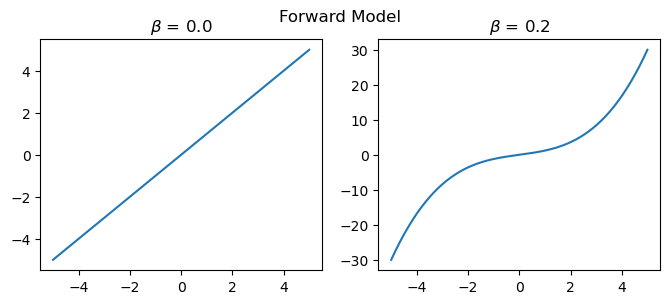

In [2]:
def forward(x, beta):
    """Simple model: y = x (1 + β x²) (linear if beta=0)."""
    return x * (1 + beta * x**2)

fig, axs = plt.subplots(1, 2, figsize=(8,3), sharex=True)
fig.suptitle('Forward Model')
px = np.linspace(-5, 5, 301)
for i, b in enumerate([0.0, 0.2]):
    axs[i].set_title(f"$\\beta$ = {b}")
    axs[i].plot(px, forward(px, b))

## True model parameters (in reality not known)

**The notebook should work for an arbitrary number of model parameter and observations. `ipf` and `iof` are the indices of the shown curves for parameter and observation, respectively.**

In [3]:
# Beta parameter: if 0 -> linear; else non-linear
beta = 0.0
#beta = 0.2

mtrue = np.array([-1.0, ])
#mtrue = np.array([-1.0, 0.0, 2.0])  # For the 3-param-2-obs model

## Observed data and associated error

**Here we forward model the observed data (inverse crime!), but in reality these are measurements.**

In [4]:
# Observations
dobs = forward(mtrue, beta)

# Associated standard deviation: ones (for this scenario)
obs_std = np.ones(dobs.size)
obs_var = obs_std**2

## Prior model parameters

In reality, the prior would be $j$ models provided by, e.g., the geologists. Here we create $j$ realizations using a normal distribution of a defined mean and standard deviation.

In [5]:
# Number of observations and model parameters
nd = dobs.size
nm = mtrue.size

# Ensemble size (Geir used for the figures 1e7)
# (Reduce to speed up; costly is the pd-estimation for plotting, not ES-MDA)
ne = int(1e5)

# Prior: Let's start with ones
mprior_mean = np.ones(nm)
par_std = np.ones(nm)
mprior_init = rng.normal(loc=mprior_mean, scale=par_std, size=(ne, nm)).T

## ES-MDA function

In [6]:
def esmda(fwd, mprior, alphas, dobs, obs_var, args=(), kwargs={}, return_steps=False):
    """Simple ES-MDA function for testing."""

    # Check alphas
    if np.sum(1/alphas) - 1.0 > 0.001:
        raise ValueError(f"sum(1/alpha) != 1:  {np.sum(1/alphas):.2f}")

    # Get shapes
    nm, ne = mprior.shape
    nd = dobs.size
    
    # Pre-allocate output if return_steps
    if return_steps:
        mprior_out = np.zeros((alphas.size+1, nm, ne))
        dpred_out = np.zeros((alphas.size+1, nd, ne))

    # Loop over alphas
    for i, alpha in enumerate(alphas):

        # Run the ensemble from time zero
        dpred = forward(mprior, *args, **kwargs)
        
        # Store if required
        if return_steps:
            mprior_out[i, :, :] = mprior
            dpred_out[i, :, :] = dpred

        # Perturb the observation vector
        scale = np.sqrt(alpha * obs_var)[:, None]  # NOTE: double-check scale, correct?
        # => PROBLEM 1: RESULT IS SUPER DEPENDENT ON `scale`
        duc = rng.normal(loc=dobs[:, None], scale=scale, size=(nd, ne))  # nd x ne

        # Covariances
        dcent = dpred - dpred.mean(axis=1, keepdims=True)    # nd x ne
        mcent = mprior - mprior.mean(axis=1, keepdims=True)  # nm x ne
        cmd = mcent @ dcent.T  # nm x nd
        cdd = dcent @ dcent.T  # nd x nd

        # Invert C
        c = np.linalg.pinv(cdd + alpha * obs_var[:, None])

        # Update mprior; (nm x nd) x (nd x nd) x (nd x ne) = nm x ne (Equation 1)
        mprior += cmd @ c @ (duc - dpred) / alphas.size
        # => PROBLEM 2: WHY DIVIDE BY alphas.size?????? SUPER DEPENDENT ON THAT TOO

    # Return steps if asked for
    if return_steps:
        mprior_out[-1, :, :] = mprior
        dpred_out[-1, :, :] = forward(mprior, *args, **kwargs)  # Final prediction
        return {'dpred': dpred_out, 'mprior': mprior_out}

## Plotting settings

In [7]:
# Only used to estimate the PDF's (for illustration purposes)
# Note: This is expensive for large ne's!
def kde(data, points, i):
    return stats.gaussian_kde(data[i, :]).evaluate(points)

# Parameter and Observation ranges
par_domain = np.linspace(-3, 5, 101)
obs_domain = np.linspace(-5, 8, 101)

# Index to select for figures (only relevant for multi-{parameter/observation} models)
ipf = 0  # parameter index
iof = 0  # observation index

## Run ES-MDA and plot

Number of ensembles   : 100,000

 -- Model Parameters --
'True' (unknown) : [-1.]
Forecast (mean)  : [1.00322767]
Analysis (mean)  : [-0.3047855]

 -- Data --
'Observed'       : [-1.]
Forecast (mean)  : [1.00322767]
Analysis (mean)  : [-0.3047855]


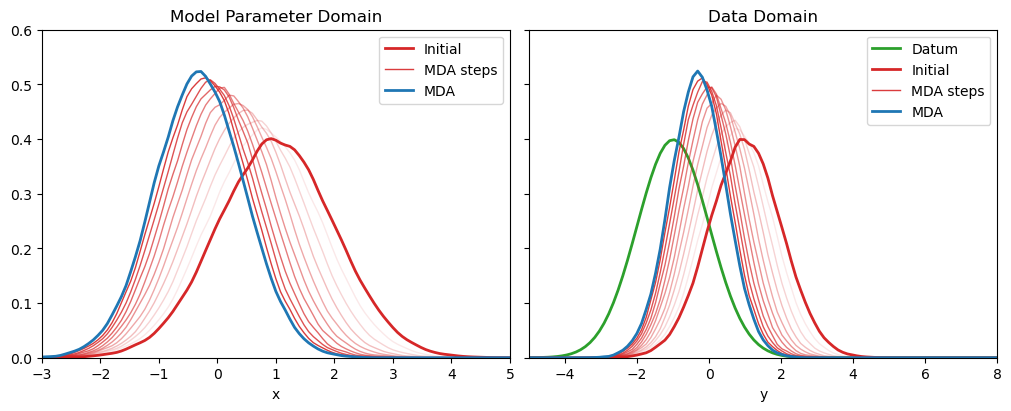

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, constrained_layout=True)

# Plot Likelihood
ax2.plot(obs_domain, stats.norm.pdf(obs_domain, loc=dobs[iof], scale=obs_std[iof]), 'C2', lw=2, label='Datum')

# Choose the coefficients alpha (condition: sum(1/a) = 1) 
alphas = 10*np.ones(10)
#alphas = np.array([9.3333, 7, 4, 2])

# RUN ES-MDA
# (copy the prior so this cell can be run several times without changing)
mprior = mprior_init.copy()
out = esmda(forward, mprior, alphas, dobs, obs_var, kwargs={'beta': beta}, return_steps=True)

# Plot step
for i in range(alphas.size+1):
    params = {
        'color': 'C0' if i == alphas.size else 'C3',  # Last blue, rest red
        'lw': 2 if i in [0, alphas.size] else 1,      # First/last thick
        'alpha': 1 if i in [0, alphas.size] else i/alphas.size,  # start faint
        'label': ['Initial', *((alphas.size-2)*('',)), 'MDA steps', 'MDA'][i],
    }
    
    ax1.plot(par_domain, kde(out['mprior'][i, :, :], par_domain, ipf), **params)
    ax2.plot(obs_domain, kde(out['dpred'][i, :, :], obs_domain, iof), **params)

# Axis and labels
ax1.set_title('Model Parameter Domain')
ax1.set_xlabel('x')
ax1.set_ylim([0, 0.6])
ax1.set_xlim([-3, 5])
ax1.legend()
ax2.set_title('Data Domain')
ax2.set_xlabel('y')
ax2.set_xlim([-5, 8])
ax2.legend()

print(f"Number of ensembles   : {ne:,}")
print("\n -- Model Parameters --")
print(f"'True' (unknown) : {mtrue}")
print(f"Forecast (mean)  : {mprior_init.mean(axis=1)}")
print(f"Analysis (mean)  : {mprior.mean(axis=1)}")
print("\n -- Data --")
print(f"'Observed'       : {dobs}")
print(f"Forecast (mean)  : {out['dpred'][0, :, :].mean(axis=1)}")
print(f"Analysis (mean)  : {out['dpred'][-1, :, :].mean(axis=1)}")

## Issues

- The plots are similar, but _not_ the same. In Geir's figures, the model parameter converges to "0".
- I scale the update by 1/na, which is NOT in the equations

<img src="figures/Geir-IrisTalk-2017-34.png" alt="Geir-IrisTalk-2017-35" style="width: 400px;"/>
<img src="figures/Geir-IrisTalk-2017-35.png" alt="Geir-IrisTalk-2017-35" style="width: 400px;"/>

In [9]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Wed May 03 17:01:51 2023 CEST

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.23.5
             scipy : 1.10.1
           IPython : 8.12.0
        matplotlib : 3.7.1
            scooby : 0.7.1

  Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------